For Collab

In [ ]:
!git clone https://github.com/GerardTho/Deep_image_prior_inpainting.git

In [ ]:
cd Deep_image_prior_inpainting

In [1]:
import torch
import numpy as np
from PIL import Image

import utils
from model.EncoderDecoder import EncoderDecoder
from model.EncoderDecoderSkipConnections import EncoderDecoderSkipConnections
from model.EncoderDecoderResidualConnections import EncoderDecoderResidualConnections
from model.EdgeModeInpainting import InpaintGenerator, EdgeGenerator

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [3]:
INPUT = 'noise'
input_depth = 3
LR = 0.01
num_iter = 1000
show_every = 100
figsize = 5
reg_noise_std = 0.03
OPTIMIZER = 'adam'
model_selection = "EncoderDecoder"

In [4]:
img_path  = 'data/table.jpg'
mask_path = 'data/table_mask.jpg'
img_pil, img_np = utils.get_image(img_path)
img_mask_pil, img_mask_np = utils.get_image(mask_path)
img_mask_pil = utils.crop_image(img_mask_pil, d=64)
img_pil      = utils.crop_image(img_pil, d=64)
img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)

In [5]:
if model_selection == "EncoderDecoder":
    model = EncoderDecoder(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],).to(device)
elif model_selection == "EncoderDecoderSkipConnections":
    model = EncoderDecoderSkipConnections(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        n_skip=[0,0,0,4,4,4],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],
                        k_skip=[1,1,1,1,1,1],).to(device)
elif model_selection == "EncoderDecoderResidualConnections":
    model = EncoderDecoderResidualConnections(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],).to(device)

In [6]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in model.parameters())
print ('Number of params: %d' % s)

img_var = torch.from_numpy(img_np).reshape(-1, img_np.shape[0], img_np.shape[1], img_np.shape[2]).to(device)
mask_var = torch.from_numpy(img_mask_np).reshape(-1, img_mask_np.shape[0], img_mask_np.shape[1], img_mask_np.shape[2]).to(device)

# Loss
mse = torch.nn.MSELoss()

net_input = utils.generate_noise(input_depth, img_np.shape[1:]).to(device)

Number of params: 3155763


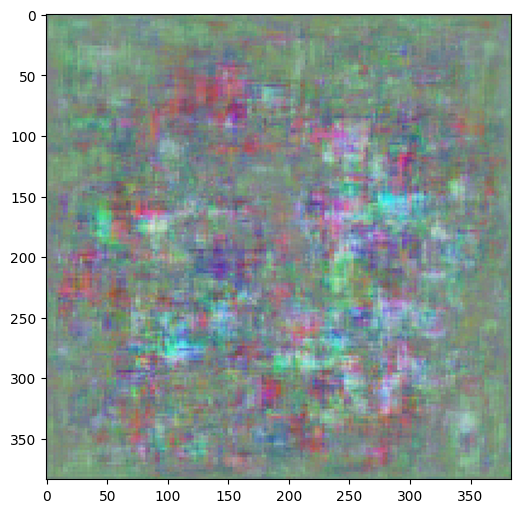

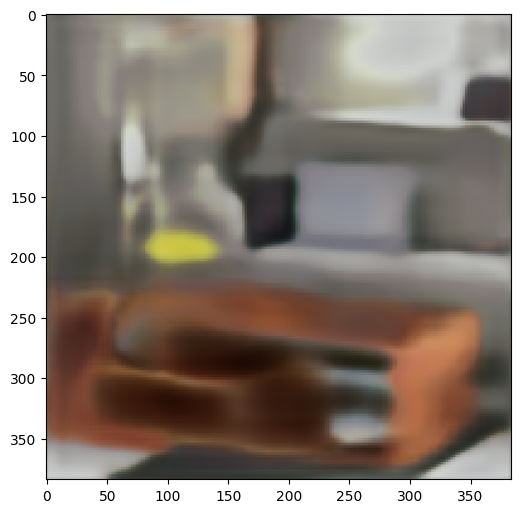

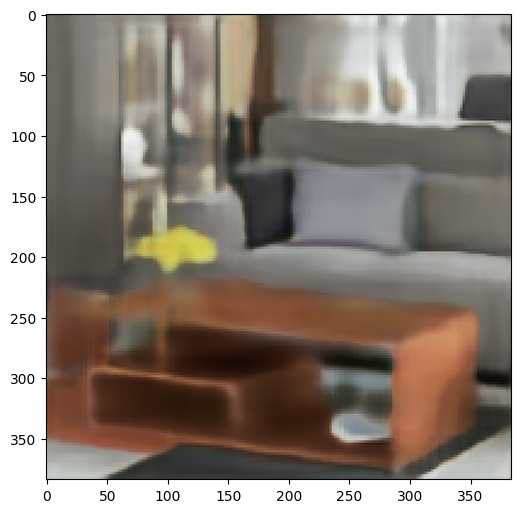

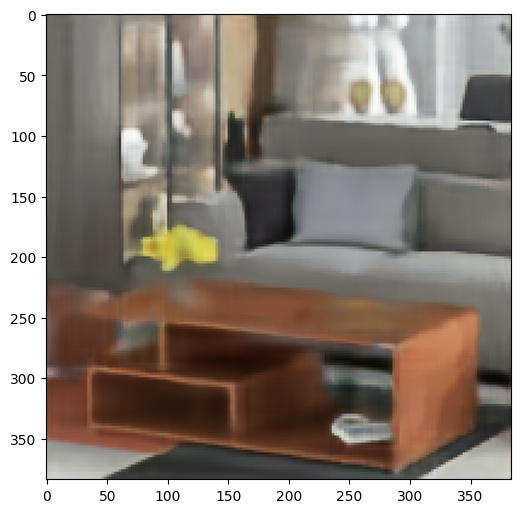

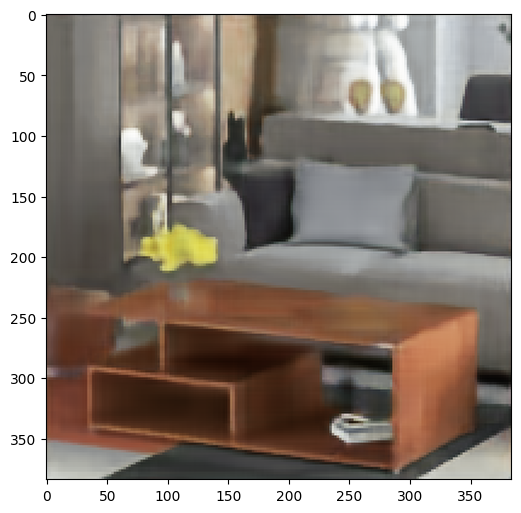

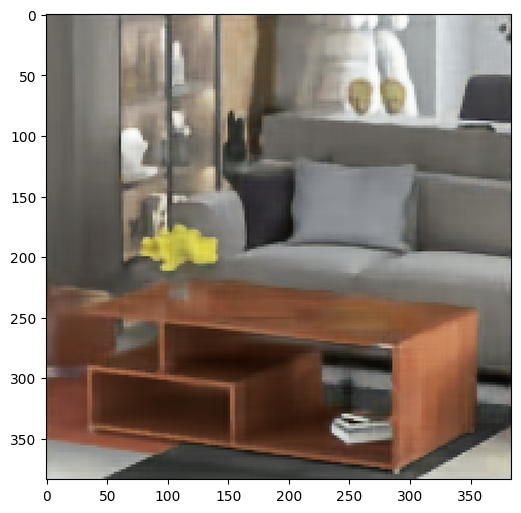

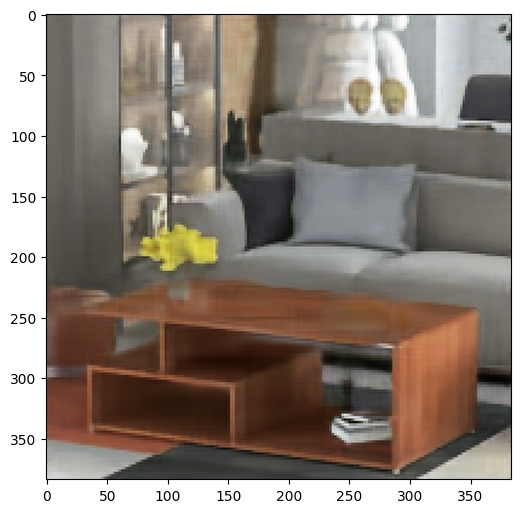

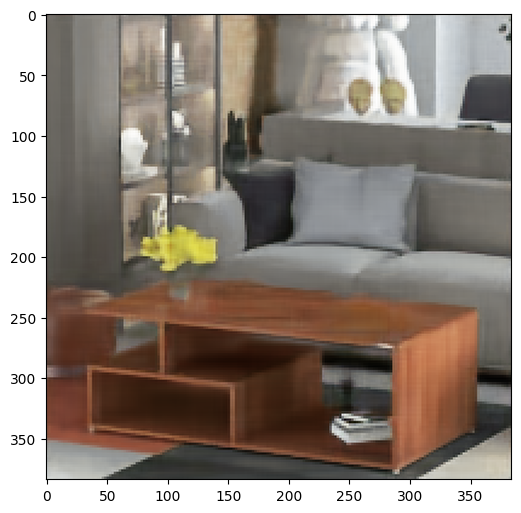

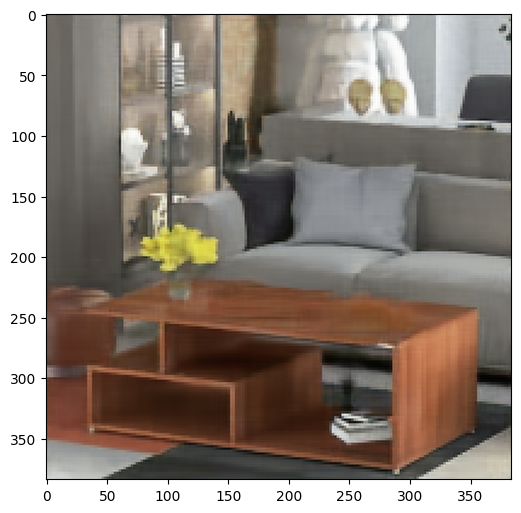

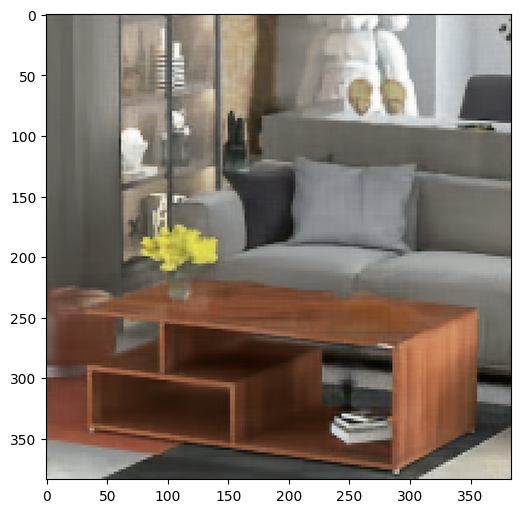

In [7]:
def optimize(parameters, LR, num_iter):
  optimizer = torch.optim.Adam(parameters, lr=LR)
  for j in range(num_iter):
    optimizer.zero_grad()

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    optimizer.step()

    print ('Iteration %05d    Loss %f' % (j, total_loss.item()), '\r', end='')
    if j % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = [x for x in model.parameters()]
optimize(p, LR, num_iter)

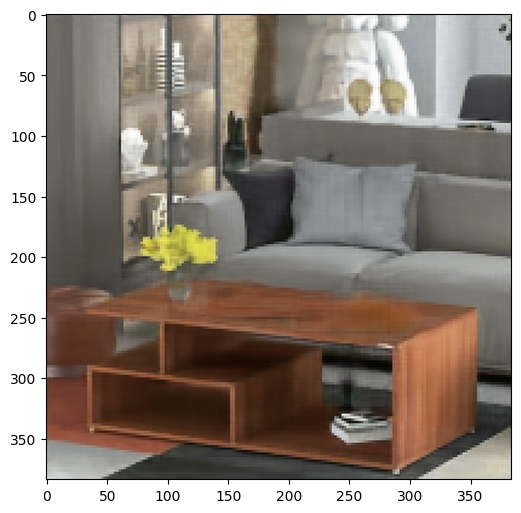

In [8]:
out_np = model(net_input).detach().cpu().numpy()[0]
utils.plot_image_grid([out_np], factor=5);

In [9]:
img_np

array([[[0.42352942, 0.43137255, 0.43137255, ..., 0.70980394,
         0.73333335, 0.7254902 ],
        [0.41960785, 0.43137255, 0.43137255, ..., 0.6784314 ,
         0.6666667 , 0.65882355],
        [0.42745098, 0.43137255, 0.43529412, ..., 0.7137255 ,
         0.73333335, 0.6784314 ],
        ...,
        [0.8235294 , 0.81960785, 0.8       , ..., 0.7764706 ,
         0.77254903, 0.79607844],
        [0.8666667 , 0.90588236, 0.8980392 , ..., 0.78039217,
         0.7882353 , 0.79607844],
        [0.7882353 , 0.78431374, 0.8117647 , ..., 0.79607844,
         0.7647059 , 0.77254903]],

       [[0.4117647 , 0.41960785, 0.41960785, ..., 0.72156864,
         0.7529412 , 0.74509805],
        [0.40784314, 0.41960785, 0.41960785, ..., 0.69803923,
         0.6862745 , 0.69411767],
        [0.41568628, 0.41960785, 0.42352942, ..., 0.7372549 ,
         0.76862746, 0.7176471 ],
        ...,
        [0.8509804 , 0.84705883, 0.83137256, ..., 0.7529412 ,
         0.7607843 , 0.78431374],
        [0.8

In [41]:
utils.PSNR(img_np, out_np)

75.3817857741644

In [42]:
img_path  = 'data/entry.jpg'
mask_path = 'data/entry_mask.jpg'
img_pil, img_np = utils.get_image(img_path)
img_pil.thumbnail((256, 256), Image.Resampling.LANCZOS)
img_mask_pil, img_mask_np = utils.get_image(mask_path)
img_mask_pil.thumbnail((256, 256), Image.Resampling.LANCZOS)
img_mask_pil = utils.crop_image(img_mask_pil)
img_pil      = utils.crop_image(img_pil)
img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)
img_masked = img_np*img_mask_np + (1-img_mask_np)

In [43]:
edge_model = EdgeGenerator(init_weights=False)
edge_model.load_state_dict(torch.load('pretrained_GAN/EdgeModel_gen.pth', map_location=device)["generator"])
inpaint_model = InpaintGenerator(init_weights=False)
inpaint_model.load_state_dict(torch.load('pretrained_GAN/InpaintingModel_gen.pth', map_location=device)["generator"])

<All keys matched successfully>

In [44]:
img_edge = edge_model(torch.from_numpy(1-img_np))

In [45]:
img_inpainted = inpaint_model(torch.cat((torch.from_numpy(img_masked), img_edge), dim=0)).detach().cpu().numpy()

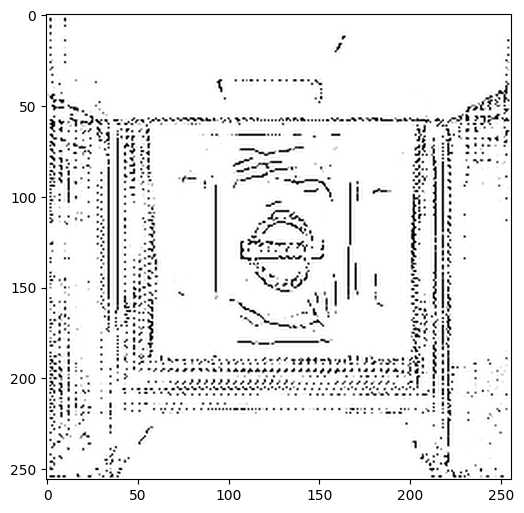

array([[[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 4.9781799e-04, ...,
         1.0000000e+00, 9.6634448e-01, 1.0000000e+00],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 8.9077014e-01, 0.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

       [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 4.9781799e-04, ...,
         1.000

In [46]:
utils.plot_image_grid([np.clip(1-img_edge.detach().cpu().numpy(), 0, 1)], factor=figsize, nrow=1)

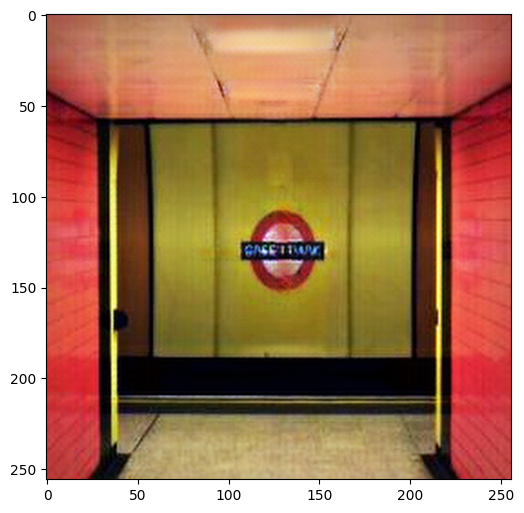

array([[[0.64157915, 0.6431851 , 0.65859795, ..., 0.6301818 ,
         0.6399674 , 0.6529698 ],
        [0.64653015, 0.6392834 , 0.65586996, ..., 0.6332407 ,
         0.63500047, 0.63563496],
        [0.6391004 , 0.6460607 , 0.657785  , ..., 0.62920713,
         0.626675  , 0.62121576],
        ...,
        [0.67820525, 0.7108294 , 0.7390982 , ..., 0.7289733 ,
         0.74106175, 0.76644146],
        [0.70906544, 0.7190856 , 0.7279874 , ..., 0.72909087,
         0.7557187 , 0.7680017 ],
        [0.7137625 , 0.7058466 , 0.70311344, ..., 0.7205679 ,
         0.7659456 , 0.7590547 ]],

       [[0.3114708 , 0.32663453, 0.32630205, ..., 0.30812487,
         0.30047655, 0.30314064],
        [0.3208002 , 0.32903674, 0.33117425, ..., 0.31111068,
         0.30299118, 0.29817975],
        [0.32647273, 0.34437817, 0.34860224, ..., 0.30857226,
         0.29722118, 0.28163064],
        ...,
        [0.19945025, 0.22461602, 0.24360117, ..., 0.26779684,
         0.26680776, 0.28368515],
        [0.2

In [47]:
utils.plot_image_grid([np.clip(img_inpainted, 0, 1)], factor=figsize, nrow=1)

In [48]:
utils.PSNR(img_np ,img_inpainted)

74.13364114218712